## Install the matrice package or upgrade it if already installed

In [ ]:
#!python -m pip install --upgrade --index-url https://test.pypi.org/simple/ --no-deps matrice
#!python -m pip install --upgrade matrice

In [11]:
!python -m pip install --upgrade matrice

  Attempting uninstall: matrice
    Found existing installation: matrice 1.0.4
    Uninstalling matrice-1.0.4:
      Successfully uninstalled matrice-1.0.4


## Install required dependencies

In [9]:
!pip install pycocotools pyyaml seaborn 

## Setting up the credentials
*   ENV
*   MATRICE_ACCESS_KEY_ID
*   MATRICE_SECRET_ACCESS_KEY
*   MATRICE_ACCOUNT_NUMBER

In [1]:
import yaml
import os

class Vars:
    _data = {}
    _path = None

    @classmethod
    def initialize(cls, path):
        cls._path = path
        cls._data = cls.load()

    @classmethod
    def load(cls):
        if cls._path and os.path.exists(cls._path):
            with open(cls._path, 'r') as f:
                return yaml.safe_load(f)
        return {}

    @classmethod
    def get(cls, key):
        if key not in cls._data:
            raise KeyError(f"Variable {key} not found")
        return cls._data[key]

    @classmethod
    def set(cls, key, value):
        cls._data[key] = value
        with open(cls._path, 'w') as f:
            yaml.safe_dump(cls._data, f, default_flow_style=False)


In [2]:
Vars.initialize('vars.yaml')

In [3]:
Vars.set("ENV", "prod")
Vars.set("MATRICE_ACCESS_KEY_ID", "7NCF9F********")
Vars.set("MATRICE_SECRET_ACCESS_KEY", "XXVY9GUB********")
Vars.set("MATRICE_ACCOUNT_NUMBER", "9782886768719********")

In [4]:
import os
os.environ['ENV'] = Vars.get('ENV')
access_key = Vars.get('MATRICE_ACCESS_KEY_ID')
secret_key = Vars.get('MATRICE_SECRET_ACCESS_KEY')
account_number = Vars.get('MATRICE_ACCOUNT_NUMBER')

## Import required matrice modules

In [5]:
from matrice.session import Session
from matrice.projects import Projects
from matrice.dataset import Dataset
from matrice.models import Model
from matrice.deployment import Deployment
from matrice.exported_model import ExportedModel
import sys
import os

# Create Image Classification Project with Matrice SDK

1.   Initialize matrice connection session
2.   List projects in user account
3.   Create the Project
4.   Update the session with the project_id

In [6]:
session_instance = Session.create_session(account_number=account_number, access_key=access_key, secret_key=secret_key)
print("A Session has been initialized:", session_instance)

A Session has been initialized: <matrice.session.Session object at 0x00000212E564A5D0>


In [7]:
projects_list, msg = session_instance.list_projects(project_type="classification")

# Check if there is a message or error
if msg:
    print(f"Message: {msg}")

# Print the projects in a formatted manner
for project_name, project_instance in projects_list.items():
    print(f"Project Name: {project_name} | Project ID: {project_instance.project_id}")

Message: Projects fetched successfully
Project Name: Face Recognition for Security | Project ID: 672c4da4c1c6122f225f6618
Project Name: Shoplifting Detection in Retail Stores | Project ID: 66dfe3448ec9ba77e5974a1a
Project Name: test-classification | Project ID: 661cee5e5506d86e3ef76fcf
Project Name: Test-Detection-0 | Project ID: 662f4df5d10f1cae145bdbd9
Project Name: test -1 | Project ID: 66f2ce5d35ebeaa9146ca94e
Project Name: detection-testing | Project ID: 6621eca55506d86e3ef77099
Project Name: Sid Test Project | Project ID: 6613bae85506d86e3ef76f97


In [8]:
project_name = "Face Recognition for Security"
for name, project_instance in projects_list.items():
    if name == project_name:
        projects_instance = Projects(session_instance, project_name=project_name)
        session_instance.update(projects_instance.project_id)
        print(f"Project '{project_name}' already exists. Initialized Projects instance.")
        project_exists = True
        break
    else:
        project_exists = False

if project_exists == False:
    print(f"Creating a new project: {project_name}")


Project 'Face Recognition for Security' already exists. Initialized Projects instance.


In [9]:
import pprint

name = "Face Recognition for Security"
# Function to create a project
def create_project():
    project_name = name
    input_type = "image"
    output_type = "classification"
    
    enabled_platforms = {
        "matrice": True,
        "android": False,
        "ios": False,
        "tpu": False,
        "intelCPU": False,
        "gcloudGPU": False
    }

    resp, error = session_instance._create_project(project_name, input_type, output_type)
    if error:
        print(f"Error: {error}")
        return None, None
    else:
        print(f"Project created with ID: {resp['_id']}")
        return resp['_id'], resp['name']

# Check if project_id and project_name exist
project_id = None
project_name = None

if not project_exists:
    project_id, project_name = create_project()
else:
    project_id = projects_instance.project_id
    project_name = projects_instance.project_name
    print(f"Project already exists with ID: {project_id} and Name: {project_name}")


print("----------------------------")
print(f"Project ID: {project_id}")
print(f"Project Name: {project_name}")
print("----------------------------")


Project created with ID: 672c4da4c1c6122f225f6618
----------------------------
Project ID: 672c4da4c1c6122f225f6618
Project Name: Face Recognition for Security
----------------------------


In [10]:
Vars.set("project_name",project_name)
Vars.set("project_id", project_id)

In [11]:
session_instance.update(project_id)
project_instance = Projects(session_instance, project_name=project_name)
print("A Project class has been initialized",project_instance)

A Project class has been initialized <matrice.projects.Projects object at 0x000002614E7D2720>


# Preparing the Dataset


1.   Dataset Downlaod (either local download or use scripts to download)
2.   Dataset Exploration
3.   Plot Samples from the Dataset
4.   Dataset Format Preparation in Imagenet
5.   Compress the Dataset to be ready for uploading

In [12]:
import zipfile
import os
import shutil
import pandas as pd
from pathlib import Path

def zip_folder(folder_path, output_zip_path):
    """Zips the given folder into a zip file at the specified output path."""
    shutil.make_archive(output_zip_path, 'zip', folder_path)

def extract_zip(zip_file_path, extract_to_folder):
    """Extracts the zip file to a specified folder."""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)

def find_inner_faces_folder(faces_folder):
    """
    Checks if there is an extra 'Faces' folder inside the main 'Faces' folder.
    If it exists, return the path to the inner folder.
    """
    inner_faces_folder = os.path.join(faces_folder, 'Faces')
    return inner_faces_folder if os.path.isdir(inner_faces_folder) else faces_folder

def organize_images_from_csv(faces_folder, csv_file_path, imagenet_folder):
    """
    Organizes images into ImageNet format based on a CSV file.
    Assumes the CSV file has columns 'id' and 'label'.
    """
    # Create the ImageNet root folder
    Path(imagenet_folder).mkdir(parents=True, exist_ok=True)
    
    # Load the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Iterate through each row in the CSV file
    for _, row in df.iterrows():
        image_name = row['id']  # Image filename
        label = row['label']    # Class name

        # Define the source path and target path
        src_path = os.path.join(faces_folder, image_name)
        target_class_folder = os.path.join(imagenet_folder, label)
        
        # Check if the source file exists
        if not os.path.isfile(src_path):
            print(f"Warning: Image '{image_name}' not found in '{faces_folder}'. Skipping.")
            continue
        
        # Create the target class directory if it doesn't exist
        Path(target_class_folder).mkdir(parents=True, exist_ok=True)
        
        # Copy the image file to the target directory
        shutil.copy(src_path, os.path.join(target_class_folder, image_name))

# Example usage:
zip_file_path = r"C:\Personal\matrice\Face Recognition for Security\Face_recog_dataset.zip"  # Path to the zip file
extract_to_folder = 'extracted_dataset'           # Temporary extraction folder
imagenet_folder = 'imagenet_format_data'          # Final ImageNet format folder

# Step 1: Extract the zip file
extract_zip(zip_file_path, extract_to_folder)

# Step 2: Identify the correct faces folder
faces_folder = find_inner_faces_folder(os.path.join(extract_to_folder, 'Faces'))
csv_file_path = os.path.join(extract_to_folder, 'Dataset.csv')

# Step 3: Organize images based on CSV labels
organize_images_from_csv(faces_folder, csv_file_path, imagenet_folder)

print("Dataset has been converted to ImageNet format.")

output_zip_path = 'imagenet_format_data_zip' 
zip_folder(imagenet_folder, output_zip_path)


Dataset has been converted to ImageNet format.


# Import the Dataset to the project


1.   Upload the dataset
2.   Start a data import action
3.   Check the status of the dataset import action
4.   Check the processed dataset information

Upload the dataset

For uploading the dataset you have 2 options:-


*   Upload the dataset to cloud storage bucket with `project.upload_cloud_dataset()`
*   Upload the dataset from your local storage with `project.upload_local_dataset() `

In [13]:
dataset, dataset_action = project_instance.import_local_dataset(
    dataset_name='Face recognition for security',
    file_path = r"C:\Personal\matrice\Face Recognition for Security\imagenet_format_data_zip.zip",
    dataset_type = "classification",
    dataset_description = "This dataset contains photos of various famous celebrities",
    version_description = "1st version",
    input_type = "image"
)


In [14]:
dataset_id = dataset.dataset_id
action_id = dataset_action.action_id

print(f"Dataset ID: {dataset_id}")
print(f"Action ID: {action_id}")

Dataset ID: 672c4e50d7ca08f1f0d9fd1e
Action ID: 672c4e51c1c6122f225f6619


In [15]:
Vars.set("dataset_id", dataset.dataset_id)
Vars.set("dataset_action_id", dataset_action.action_id)

In [26]:
import time
import pprint

action_id = dataset_action.action_id
def check_dataset_status():
    while True:
        print(" ")
        print("-------Status------")
        D = Dataset(session_instance, dataset_id=dataset_id)
        status = D.version_status
        print("Status of dataset:", status)
        print("-------------------")
        if status == 'processed':
            print("---------Preprocessing Complete---------")
            print("Dataset processed, proceed with experiment creation.")
            print("---------------------------------------")
            break
        
        time.sleep(90)  # Wait for 90 seconds before checking again

# Run the function to check dataset status
check_dataset_status()


 
-------Status------
Status of dataset: processed
-------------------
---------Preprocessing Complete---------
Dataset processed, proceed with experiment creation.
---------------------------------------


In [16]:
def print_dataset_info(dataset):
   
    dataset_id = dataset.dataset_details['_id']
    dataset_name = dataset.dataset_details['name']
    version_status = dataset.dataset_details.get("stats", [{}])[0].get("versionStatus")
    latest_version = dataset.dataset_details['latestVersion']
    no_of_samples = sum(version['versionStats']['total'] for version in dataset.dataset_details.get('stats', []))
    no_of_classes = len(dataset.dataset_details.get('stats', [{}])[0].get('classStat', {}))
    no_of_versions = len(dataset.dataset_details.get('allVersions', []))
    last_updated_at = dataset.dataset_details.get('updatedAt')

    print(f"Dataset ID: {dataset_id}")
    print(f"Dataset Name: {dataset_name}")
    print(f"Version Status: {version_status}")
    print(f"Latest Version: {latest_version}")
    print(f"Number of Samples: {no_of_samples}")
    print(f"Number of Classes: {no_of_classes}")
    print(f"Number of Versions: {no_of_versions}")
    print(f"Last Updated At: {last_updated_at}")

dataset.refresh()   
print_dataset_info(dataset)

Dataset ID: 672c4e50d7ca08f1f0d9fd1e
Dataset Name: Face recognition for security
Version Status: processed
Latest Version: v1.0
Number of Samples: 2562
Number of Classes: 31
Number of Versions: 1
Last Updated At: 2024-11-07T05:33:00.656Z


In [17]:
def calculate_split_counts(total_samples, train_pct, val_pct, test_pct):
    # Ensure that percentages add up to 100
    if train_pct + val_pct + test_pct != 100:
        raise ValueError("Train, validation, and test percentages must sum up to 100.")

    # Calculate the number of samples for each split
    train_num = round(total_samples * (train_pct / 100))
    val_num = round(total_samples * (val_pct / 100))
    test_num = total_samples - train_num - val_num  # Assign remaining to test to ensure total matches

    return train_num, val_num, test_num

def create_transfers_array(train_num, val_num, test_num):
    transfers = [
        {"source": "unassigned", "destination": "train", "transferAmount": train_num},
        {"source": "unassigned", "destination": "validation", "transferAmount": val_num},
        {"source": "unassigned", "destination": "test", "transferAmount": test_num},
    ]
    return transfers

train_pct = 70
val_pct = 15
test_pct = 15
total_samples = sum(version['versionStats']['total'] for version in dataset.dataset_details.get('stats', []))
train_num, val_num, test_num = calculate_split_counts(total_samples, train_pct, val_pct, test_pct)
print(f"Train samples: {train_num}, Validation samples: {val_num}, Test samples: {test_num}")
transfers = create_transfers_array(train_num, val_num, test_num)
response, err, msg = dataset.split_data(
     old_dataset_version="v1.0",
     new_dataset_version="v1.1",
     is_random_split=True,
     train_num=train_num,
     val_num=val_num,
     test_num=test_num,
     transfers=transfers
)
if err:
    print(err)
else:
    print(response)

Train samples: 1793, Validation samples: 384, Test samples: 385
{'_datasetId': '672c4e50d7ca08f1f0d9fd1e', 'trainCount': 1793, 'valCount': 384, 'testCount': 385, 'unassignedCount': 0, 'version': 'v1.1', '_idAction': '672c51a2c1c6122f225f6629'}


In [20]:
import pprint
pprint.pprint(dataset.summary)
dataset_summary = dataset.summary

{'categoryCount': 31,
 'dataItemCount': 2562,
 'histogram': [{'_id': '672c502abf54d172c78497cd',
                'count': 108,
                'label': 'Jessica Alba',
                'test': 0,
                'train': 0,
                'unassigned': 108,
                'val': 0},
               {'_id': '672c502abf54d172c78497d8',
                'count': 71,
                'label': 'Elizabeth Olsen',
                'test': 0,
                'train': 0,
                'unassigned': 71,
                'val': 0},
               {'_id': '672c502abf54d172c78497da',
                'count': 113,
                'label': 'Robert Downey Jr',
                'test': 0,
                'train': 0,
                'unassigned': 113,
                'val': 0},
               {'_id': '672c502abf54d172c78497dc',
                'count': 92,
                'label': 'Alexandra Daddario',
                'test': 0,
                'train': 0,
                'unassigned': 92,
                

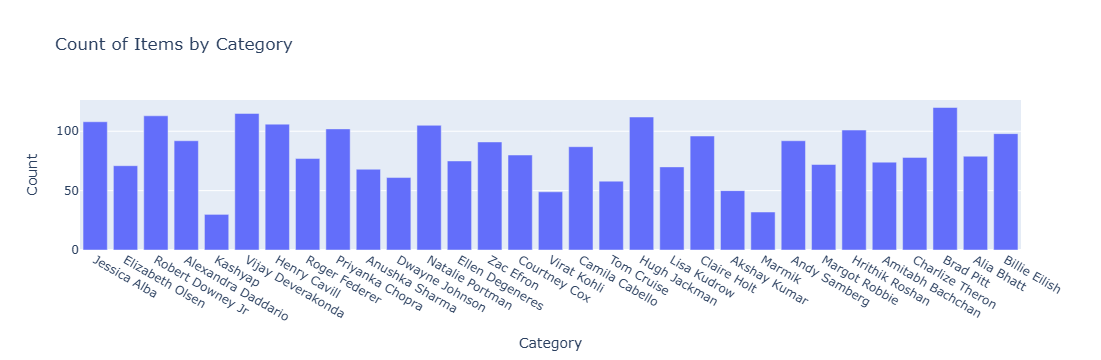

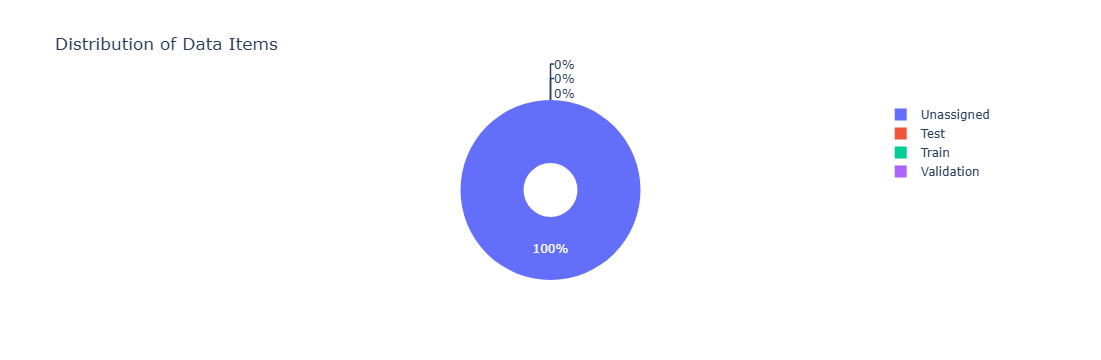

In [21]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio


# Convert the histogram data to a DataFrame
df = pd.DataFrame(dataset_summary['histogram'])

# Bar chart for counts by category
fig1 = go.Figure(data=[go.Bar(x=df['label'], y=df['count'])])
fig1.update_layout(
    title='Count of Items by Category',
    xaxis_title='Category',
    yaxis_title='Count'
)

# Pie chart for distribution of data items
fig2 = go.Figure(data=[go.Pie(
    labels=['Test', 'Train', 'Unassigned', 'Validation'],
    values=[dataset_summary['testDataItemCount'], dataset_summary['trainDataItemCount'], dataset_summary['unassignedDataItemCount'], dataset_summary['valDataItemCount']],
    hole=0.3
)])
fig2.update_layout(
    title='Distribution of Data Items'
)

# Display the figures
fig1.show()
fig2.show()


# Create a Model Training experiment

1.   Start a Model Training experiment
2.   Explore the available SOTA model families and models
3.   Get the default training config , modify it if needed.
4.   Add the model for training.
5.   Check for the status of the model train action

In [42]:
import os
import json
import pprint
import uuid

# Generate a unique experiment name
experiment_name_user = f"Face Recognition Experiment-1"

# Function to create an experiment
def create_experiment():
    name = experiment_name_user
    target_run_time = ["PyTorch"]
    primary_metric = "acc@1"
    matrice_compute = True
    dataset_version = 'v1.1'

    experiment_instance = project_instance.create_experiment(
        name,
        dataset_id,
        target_run_time[0],
        dataset_version,
        primary_metric,
        matrice_compute
    )

    print(experiment_instance)
    experiment_id = experiment_instance.experiment_id
    experiment_name = experiment_instance.experiment_name

    print(f"Experiment ID: {experiment_id}")
    print(f"Experiment Name: {experiment_name}")

    return experiment_instance, experiment_id, experiment_name

# Create a new experiment
experiment_instance , experiment_id, experiment_name = create_experiment()

print("----------------------------")
print(f"Experiment ID: {experiment_id}")
print(f"Experiment Name: {experiment_name}")
print(f"Experiment instance has been created: {experiment_instance}")
print("----------------------------")

[{'_id': '672c4e50d7ca08f1f0d9fd1e', 'name': 'Face recognition for security', '_idProject': '672c4da4c1c6122f225f6618', 'status': '', 'createdAt': '2024-11-07T05:21:20.986Z', 'updatedAt': '2024-11-07T05:36:16.376Z', 'stats': [{'version': 'v1.0', 'versionStats': {'test': 0, 'train': 0, 'val': 0, 'unassigned': 2562, 'total': 2562}, 'versionDescription': '1st version', 'classStat': {'Akshay Kumar': {'total': 50, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 50}, 'Alexandra Daddario': {'total': 92, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 92}, 'Alia Bhatt': {'total': 79, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 79}, 'Amitabh Bachchan': {'total': 74, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 74}, 'Andy Samberg': {'total': 92, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 92}, 'Anushka Sharma': {'total': 68, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 68}, 'Billie Eilish': {'total': 98, 'train': 0, 'test': 0, 'val': 0, 'unassigned': 98}, 'Brad Pitt': {'total': 120, 'tra

In [43]:
Vars.set("experiment_id", experiment_instance.experiment_id)
Vars.set("experiment_name", experiment_instance.experiment_name)

In [ ]:
from matrice.model_store import _get_all_model_families 

resp , error , mesage = _get_all_model_families( session_instance , project_id , project_type="classification" )
print("----List of available classification models on platform----")
# Iterate through each model family in the response
for model_family in resp:
    # Extract _id and modelFamily (model family name)
    model_family_id = model_family.get('_id')
    name = model_family.get('modelFamily')
    
    # Print in formatted manner
    print(f"ID: {model_family_id}, Model Family Name: {name}")

In [24]:
from matrice.model_store import ModelFamily

model_family_id = "65c6772c5f34a0e8878e3ed3"
# Initialize the ModelFamily instance after choosing a Model Family
model_family_instance = ModelFamily(session_instance, model_family_id=model_family_id) # Update with the model family ID of your choice
print("A ModelFamily instance has been initialized",model_family_instance)

A ModelFamily instance has been initialized <matrice.model_store.ModelFamily object at 0x00000212FA3DA210>


In [25]:
# Fetch model architectures
arch_resp, error, message = model_family_instance.get_model_archs()
if error:
    print(f"Error: {error}")
else:
    
    # Check if resp is a list or a dictionary
    if isinstance(arch_resp, list):
        # Iterate through each model info in the list
        for model_info in arch_resp:
            model_key = model_info["model_key"]
            model_arch_instance = model_info["model_arch_instance"]
            
            # Extract model information
            model_info_id = model_arch_instance.model_info_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} |  Model Name: {name} | Model Key: {key} | Params in Millions: {params}")
    elif isinstance(arch_resp, dict):
        # Iterate through each model key in the dictionary
        for model_key, model_arch_instance in arch_resp.items():
            # Extract model information
            model_info_id = model_arch_instance.model_info_id
            name = model_arch_instance.model_name
            key = model_arch_instance.model_key
            params = model_arch_instance.params_millions

            # Print in formatted manner
            print(f"ID: {model_info_id} | Model Name: {name} | Model Key: {key} | Params in Millions: {params}")

ID: 65c6772d5f34a0e8878e3ed4 | Model Name: ResNet-50 | Model Key: resnet50 | Params in Millions: 23.9
ID: 65c6772d5f34a0e8878e3ed5 | Model Name: ResNet-101 | Model Key: resnet101 | Params in Millions: 42.8
ID: 65c6772e5f34a0e8878e3ed6 | Model Name: ResNet-18 | Model Key: resnet18 | Params in Millions: 11.4
ID: 65c6772e5f34a0e8878e3ed7 | Model Name: ResNet-34 | Model Key: resnet34 | Params in Millions: 21.5
ID: 65c6772e5f34a0e8878e3ed8 | Model Name: ResNet-152 | Model Key: resnet152 | Params in Millions: 58.5


In [26]:
from matrice.model_store import ModelArch
train_arch = 'resnet50' # Update with the model key of your choice
print("Chosen Training Architecture :" ,train_arch)
model_arch_instance = arch_resp.get(train_arch)
print("Model Architecture instance initialized for chosen training architecture :", model_arch_instance)

Chosen Training Architecture : resnet50
Model Architecture instance initialized for chosen training architecture : <matrice.model_store.ModelArch object at 0x00000212FA3D9CA0>


In [27]:
import pprint
train_instance , train_config = model_arch_instance.get_train_config(experiment_id=Vars.get('experiment_id'))
train_instance , train_config = model_arch_instance.get_train_config(experiment_id="6730d796eabd982c294b3d38")
print("-----Default Train Config------")
pprint.pprint(train_config)
print("--------------------------------")
print("-------Training instance initialized--------")
print(train_instance)

-----Default Train Config------
{'action_config': {'batch_size': {'allowedValues': [1, 2, 4, 8, 16, 32, 64],
                                  'anyValue': True,
                                  'defaultValue': 4,
                                  'hyperparameter': True,
                                  'keyName': 'batch_size',
                                  'maxValue': 1024,
                                  'minValue': 1,
                                  'selectedValues': [4],
                                  'valueType': 'int32'},
                   'epochs': {'allowedValues': [10,
                                                20,
                                                30,
                                                40,
                                                50,
                                                60,
                                                70,
                                                80,
                                      

In [49]:
model_config = train_config['model_config']

# Modify the model_config as needed
# modifications:
model_config['batch_size'] = [2]
model_config['epochs'] = [50]
model_config['learning_rate'] = [0.001]


# Repass the modified model_config into the train_config
train_config['model_config'] = model_config

# Print the updated train_config
print("-----Updated Model Config------")
pprint.pprint(train_config['model_config'])
print("--------------------------------")

# Print the updated train_config
print("-----Updated Train Config------")
pprint.pprint(train_config)
print("--------------------------------")

-----Updated Model Config------
{'batch_size': [2],
 'epochs': [50],
 'learning_rate': [0.001],
 'lr_gamma': [0.1],
 'lr_min': [1e-05],
 'lr_scheduler': ['StepLR'],
 'lr_step_size': [10],
 'min_delta': [0.0001],
 'momentum': [0.95],
 'optimizer': ['AdamW'],
 'patience': [5],
 'weight_decay': [0.0001]}
--------------------------------
-----Updated Train Config------
{'action_config': {'batch_size': {'allowedValues': [1, 2, 4, 8, 16, 32, 64],
                                  'anyValue': True,
                                  'defaultValue': 4,
                                  'hyperparameter': True,
                                  'keyName': 'batch_size',
                                  'maxValue': 1024,
                                  'minValue': 1,
                                  'selectedValues': [4],
                                  'valueType': 'int32'},
                   'epochs': {'allowedValues': [10,
                                                20,
              

In [50]:
train_resp , msg , err = experiment_instance.add_models_for_training(train_instance,train_config)
print("------------Model added for training----------")
pprint.pprint(train_resp)

------------Model added for training----------
[{'_id': '672c9b4eeabd982c294b3cad',
  '_idActionStatus': '672c9b4eecffcfd6a91bb2bb',
  '_idDataset': '672c4e50d7ca08f1f0d9fd1e',
  '_idExperiment': '672c9b03eabd982c294b3cac',
  '_idModelFamily': '000000000000000000000000',
  '_idModelInfo': '65c6772d5f34a0e8878e3ed4',
  '_idProject': '672c4da4c1c6122f225f6618',
  '_idUser': '661368b1e775b9e2fc66cf6c',
  'actionConfig': {'batch_size': {'allowedValues': [1, 2, 4, 8, 16, 32, 64],
                                  'anyValue': True,
                                  'defaultValue': 4,
                                  'hyperparameter': True,
                                  'keyName': 'batch_size',
                                  'maxValue': 1024,
                                  'minValue': 1,
                                  'selectedValues': [4],
                                  'valueType': 'int32'},
                   'epochs': {'allowedValues': [10,
                               

In [ ]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = train_resp[0]['_idActionStatus']
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    action_instance = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {action_instance.status}")
    print(f"Step Code: {action_instance.step_code}")
    print(f"Action service is : {action_instance.service_name}")
    print("---------------------")
    return action_instance.status

# Loop to check status every 2 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully trained.")
        break
    else:
        print("Model is training. Waiting 10 minutes before checking again.")
        time.sleep(200)  # Wait for 10 minutes (600 seconds)


# Check the performance of the Trained Model

*   Check the performance values
*   Plot the epochs details of the model
*   Get the evaluation results of the model
*   Downlaod the trained model

In [9]:
# model_id = train_resp[0]['_id']
model_id = "6730d7daeabd982c294b3d39"
print(f"Model ID from response data: {model_id}")
    

# Initialize the Model class with the model_id
model_instance = Model(session_instance, model_id)
print("A Model instance has been initialized : ", model_instance)

Model ID from response data: 6730d7daeabd982c294b3d39
A Model instance has been initialized :  <matrice.models.Model object at 0x00000212E564A780>


In [13]:
Vars.set("model_train_id", model_id)
Vars.set("model_train_name", model_instance.model_name)

In [14]:
# Print the test score, validation score, and best epoch
print(f"Test Score: {model_instance.test_score}")
print(f"Validation Score: {model_instance.val_score}")
print(f"Best Epoch: {model_instance.best_epoch}")

Test Score: 0.9896103739738464
Validation Score: 0.9869791865348816
Best Epoch: -1


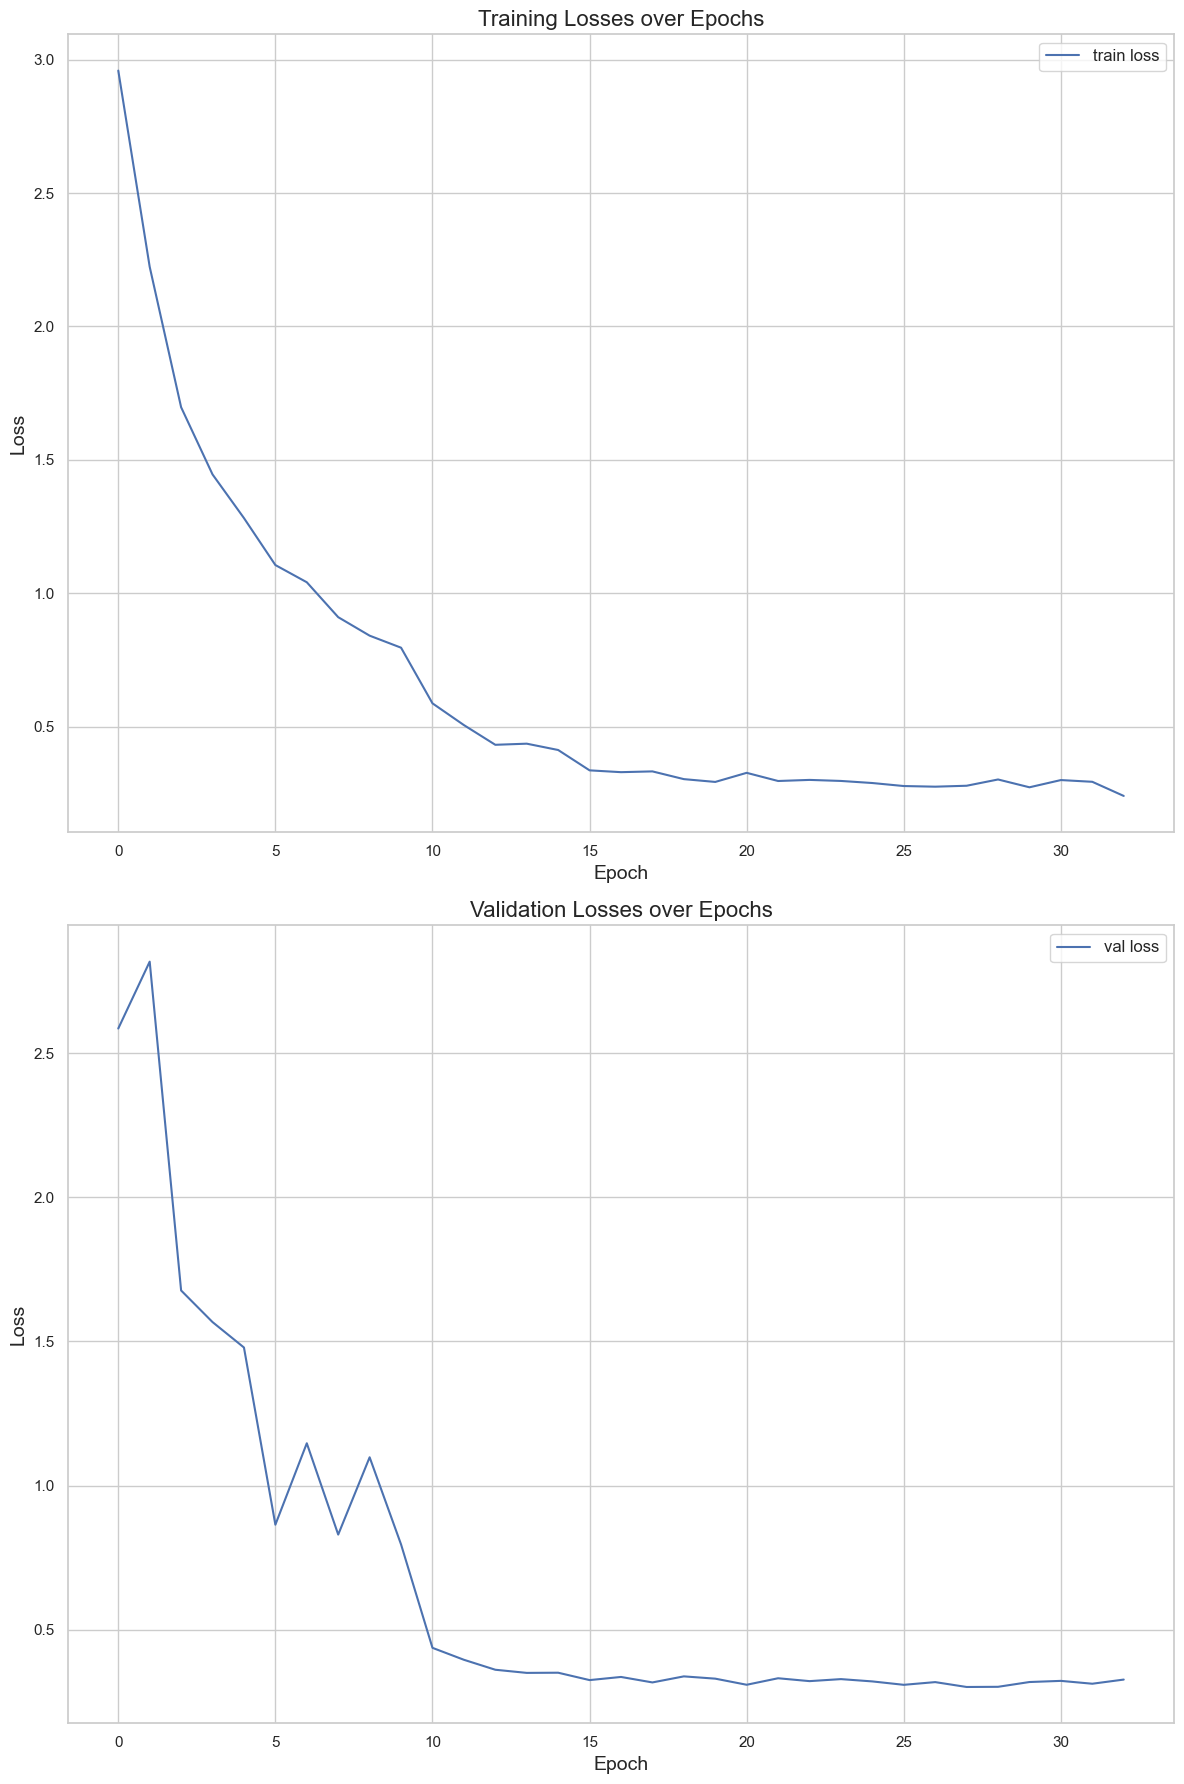

In [15]:
model_instance.plot_epochs_losses()

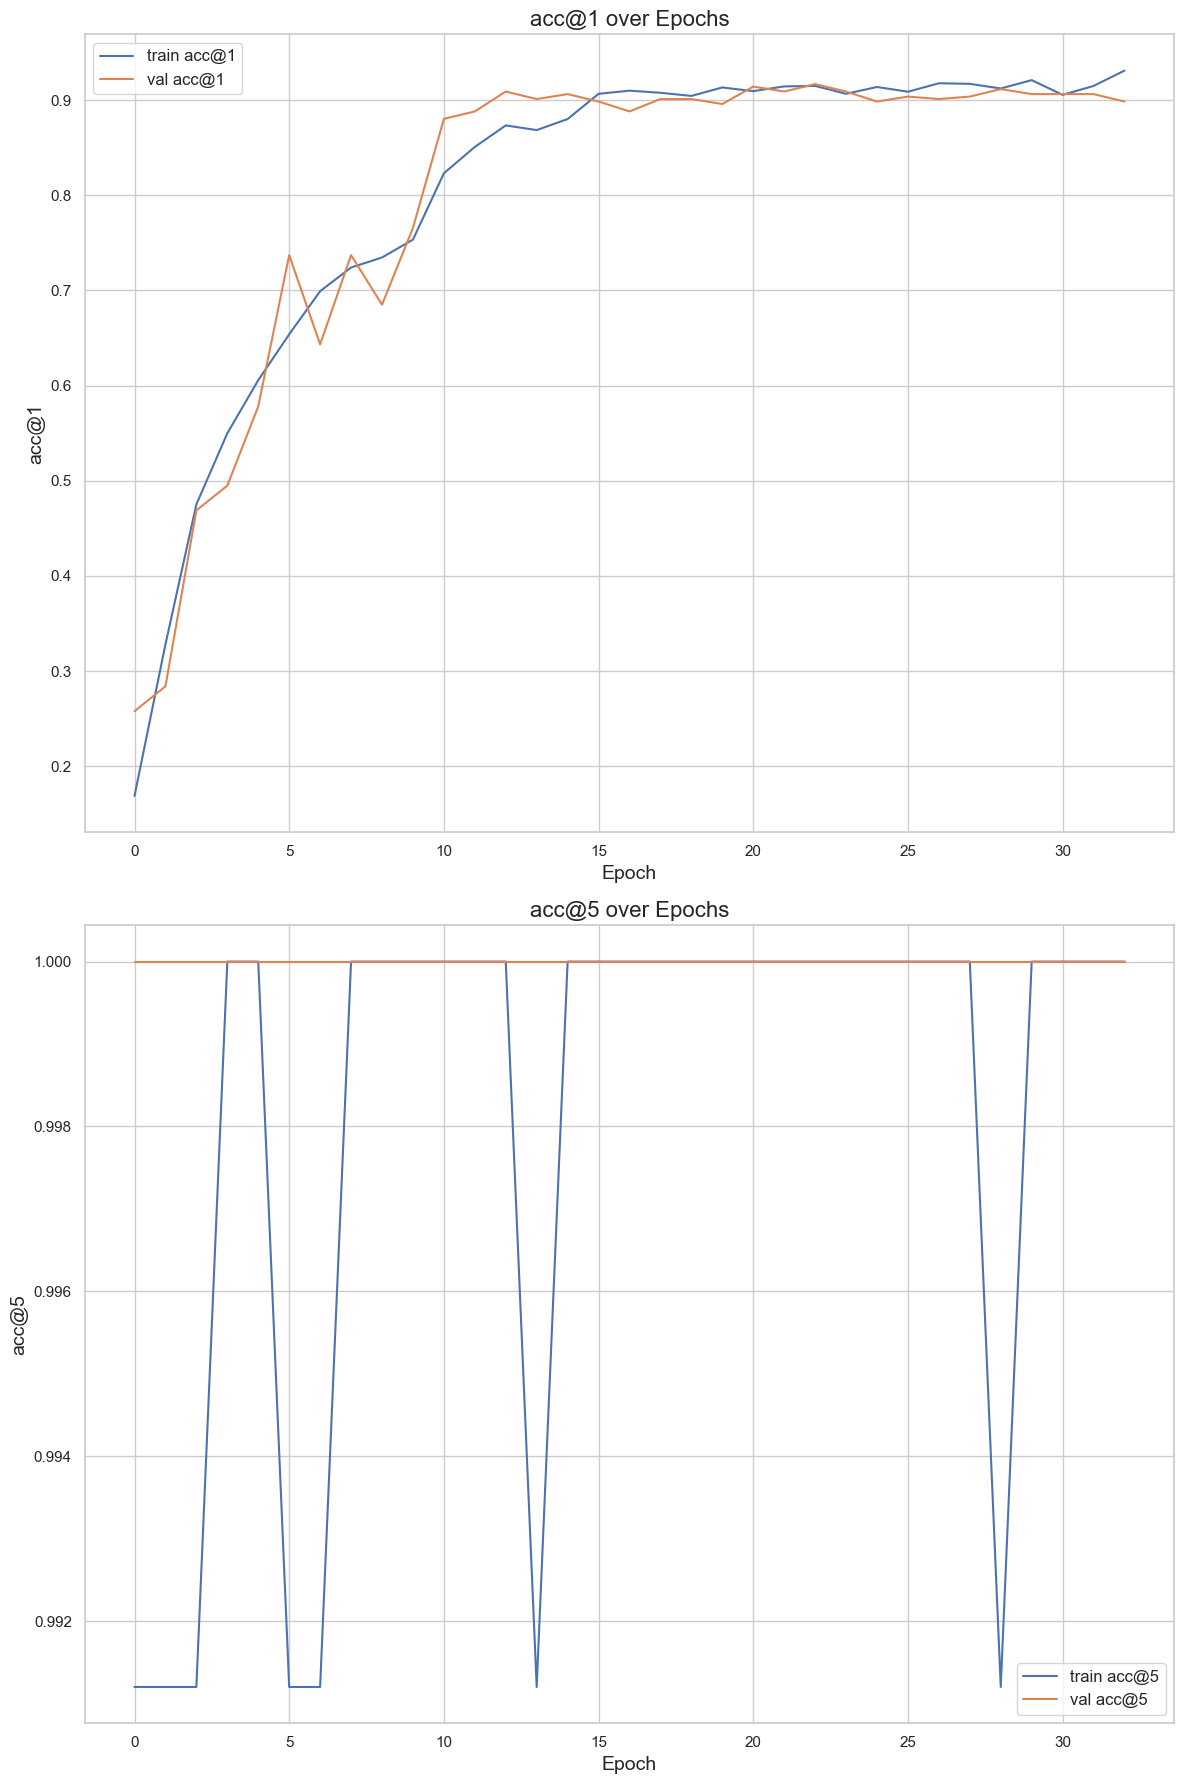

In [16]:
model_instance.plot_epochs_metrics()

C:\Users\20111\AppData\Local\Programs\Python\Python312\Lib\site-packages\matrice\models.py:350: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


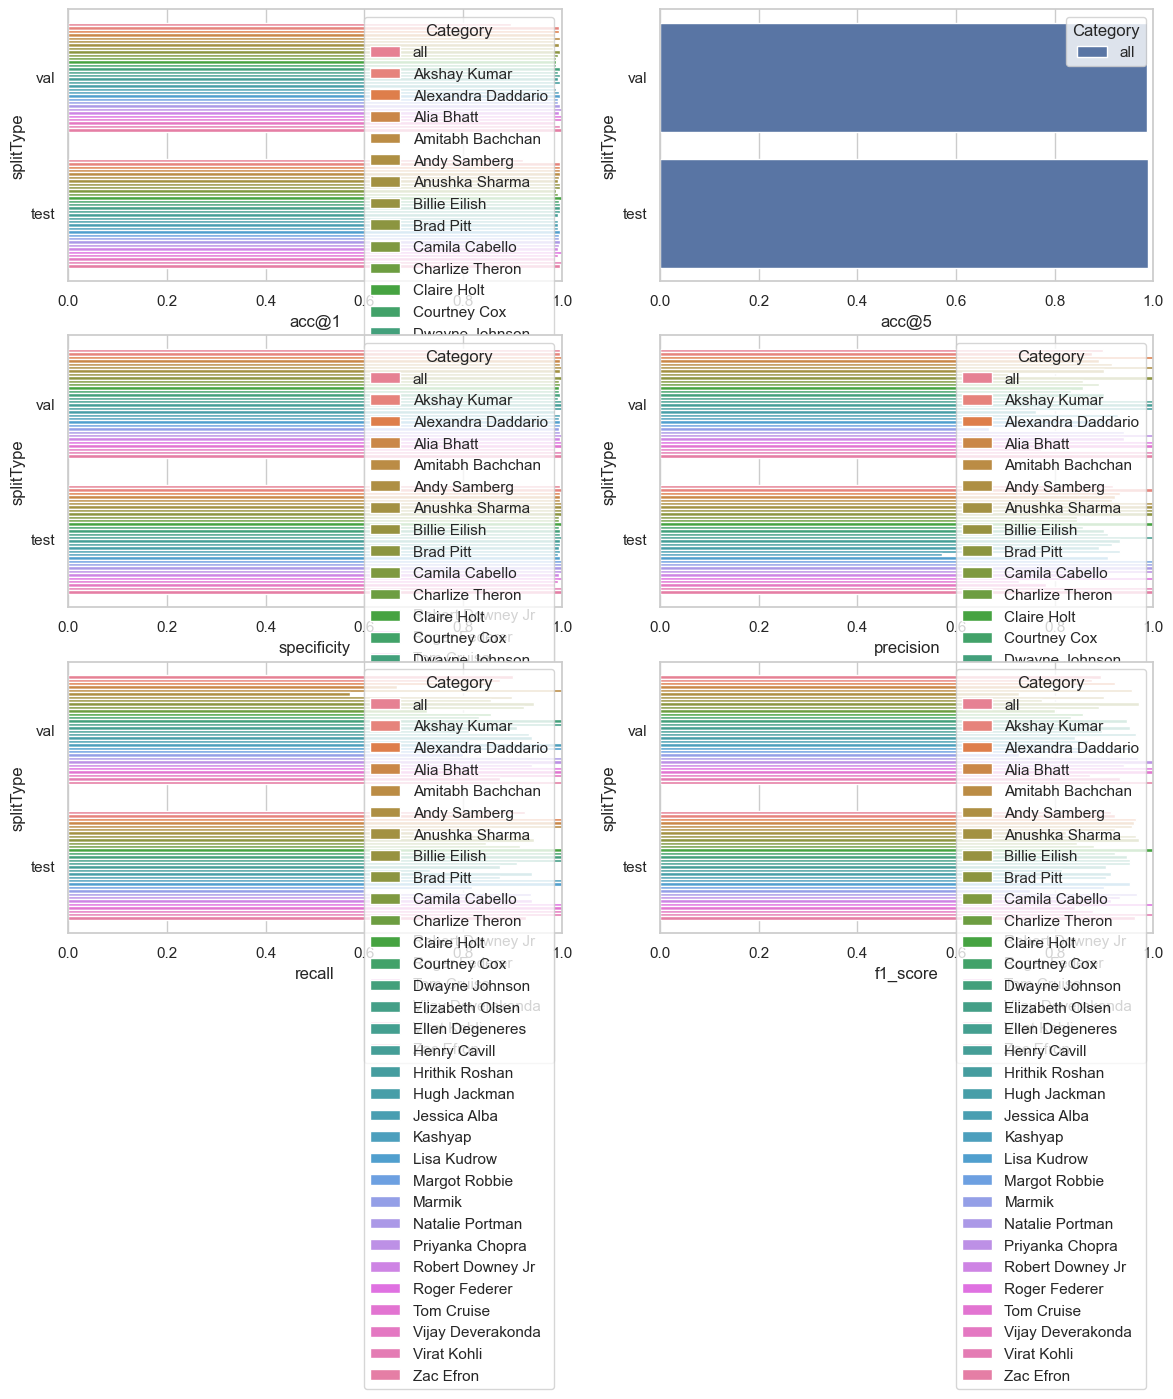

In [17]:
model_instance.plot_eval_results()

## Get test predictions on random samples from test set from the trained model 

## Classification Pred

In [18]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Define the folder path containing the images
folder_path = r"C:\Personal\matrice\Face Recognition for Security\test_images"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 2)

print(random_images)
# Loop through the selected images and make predictions
for image_file in random_images:
    # Get the prediction results from the model
    result, error, _ = model_instance.get_prediction(image_file)
    print(result)
    if error:
        print(f"Error: {error}")
        continue
    
    # Extract the predicted class label and confidence
    predicted_class = result["category"]
    confidence = result["confidence"]
    
    # Open the image
    image = Image.open(image_file)
    
    # Create a matplotlib figure and axis
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)
    
    # Add the predicted class label and confidence to the image
    plt.text(10, 10, f"{predicted_class} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))
    
    # Display the image with the annotation
    plt.show()


['C:\\Personal\\matrice\\Face Recognition for Security\\test_images\\image_1000621.jpg', 'C:\\Personal\\matrice\\Face Recognition for Security\\test_images\\image_1000307.jpg']
None
Error: runtime error: index out of range [0] with length 0
None
Error: runtime error: index out of range [0] with length 0


## Detection Pred

In [ ]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Define the folder path containing the images
folder_path = r"<path_to_test_folder>"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 10)


# Loop through the selected images and send the prediction request
for image_file in random_images:
    
    result, error, message = model_instance.get_prediction(image_file)

    if error:
        print(f"Error: {error}")
        continue

    # Extract prediction data from the result
    predictions = result

    # Open the image
    image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes and labels
    for prediction in predictions:
        category = prediction["category"]
        confidence = prediction["confidence"]
        bbox = prediction["bounding_box"]

        # Extract the bounding box coordinates
        xmin, ymin, xmax, ymax = bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]
        width, height = xmax - xmin, ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{category} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()


In [ ]:
model_instance.download_model(file_name="model.pt")

# Export the model based on usage and platform and optimzie the Model Export


1.   Create a model export action using the export config
2.   Check the status of the model export action
3.   Download the exported model

In [28]:
export_config = train_instance.get_default_export_config("ONNX") # Get the default export config for export format user wants (here ONNX)
print("Export Config for ONNX:")
pprint.pprint(export_config)

Export Config for ONNX:
{'dynamic': False, 'simplify': False}


In [29]:
exported_instance , action_instance = project_instance.create_model_export(model_id,"ONNX",export_config)

print("Model Export class has been initialized :", exported_instance)   
print("----------------------------")
print(f"Export ID: {exported_instance.model_export_id}")
print(f"Export Name: {exported_instance.model_export_name}")
print(f"Action ID: {action_instance.action_id}")
print(f"Action Status: {action_instance.status}")
print("----------------------------")

Model Export class has been initialized : <matrice.exported_model.ExportedModel object at 0x00000212F7371580>
----------------------------
Export ID: 6730fc1aeabd982c294b3d3b
Export Name: 
Action ID: 6730fc1a8c7add7d73234581
Action Status: ACK
----------------------------


In [30]:
Vars.set("model_export_id", exported_instance.model_export_id)
Vars.set("model_export_name", exported_instance.model_export_name)

In [37]:
import time
from matrice.action import Action

# Define the action ID and the status you want to check
action_id = action_instance.action_id
success_status = 'SUCCESS'

# Function to check the status of the action
def check_action_status(S, action_id):
    A = Action(S, action_id)
    print("---------------------")
    print(f"Action ID: {action_id}")
    print(f"Current Status: {A.status}")
    print(f"Step Code: {A.step_code}")
    print(f"Action service is : {A.service_name}")
    print("---------------------")
    return A.status

# Loop to check status every 1.5 minutes until it is 'success'
while True:
    status = check_action_status(session_instance, action_id)
    if status == success_status:
        print("Action status is 'success'. Model is successfully exported.")
        break
    else:
        print("Model is exporting. Waiting 2 minutes before checking again.")
        time.sleep(90)  # Wait for 1.5 minutes (90 seconds)


---------------------
Action ID: 6730fc1a8c7add7d73234581
Current Status: SUCCESS
Step Code: MDL_EXPT
Action service is : be-inference
---------------------
Action status is 'success'. Model is successfully exported.


In [38]:
exported_instance.download_model(file_name="model.onnx")

Model downloaded successfully


'model.onnx'

# Deploy the Model on Cloud

1.   Start a Model Deployment server
2.   Make Predictions on the Deployed Model

In [31]:
deployment , deployment_action = project_instance.create_deployment(
    model_id = Vars.get('model_train_id'),  # It can also be model_train_id depending on the model you want to deploy
    deployment_name = "deployment_name",
    shutdown_threshold=20
)

In [34]:
key_resp = deployment.create_auth_key(expiry_days=10)
# auth_key = key_resp['key']
auth_key = "6730fd9d06f3cf576afeb305"

In [35]:
Vars.set("deployment_id", deployment.deployment_id)
Vars.set("deployment_name", deployment.deployment_name)
Vars.set("auth_key", auth_key)

In [ ]:
import os
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Define the folder path containing the images
folder_path = r"C:\Personal\matrice\Face Recognition for Security\test_images"


# Get a list of all image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 10 images from the folder
random_images = random.sample(image_files, 10)


# Loop through the selected images and send the prediction request
for image_file in random_images:
    
    result, error, message = deployment.get_prediction(auth_key,image_file)

    if error:
        print(f"Error: {error}")
        continue

    # Extract prediction data from the result
    predictions = result

    # Open the image
    image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw bounding boxes and labels
    for prediction in predictions:
        category = prediction["category"]
        confidence = prediction["confidence"]
        bbox = prediction["bounding_box"]

        # Extract the bounding box coordinates
        xmin, ymin, xmax, ymax = bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]
        width, height = xmax - xmin, ymax - ymin

        # Create a Rectangle patch
        rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{category} ({confidence:.2f})", bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()
